## Use tesseract or easyocr to detect text only:

1) Calculate the coordinates where the text's are located in the image.
2) Draw bounding boxes on these coordinates.
3) Extract only the texts in these bounding boxes.

In [2]:
# Pip installation commands
%pip install opencv-python matplotlib torch torchvision easyocr

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install python-bidi==0.4.2

  Using cached python_bidi-0.4.2-py2.py3-none-any.whl.metadata (4.6 kB)
Using cached python_bidi-0.4.2-py2.py3-none-any.whl (30 kB)
  Attempting uninstall: python-bidi
    Found existing installation: python-bidi 0.5.0
    Uninstalling python-bidi-0.5.0:
      Successfully uninstalled python-bidi-0.5.0
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [6]:
# Import statements
import cv2
import matplotlib.pyplot as plt
import easyocr

In [7]:
# Image pre-processing

In [16]:
# Text extraction method

def extract_text_with_bounding_boxes(image_path, reader):
    # Load the image
    img = cv2.imread(image_path)

    # Detect text in the image
    result = reader.readtext(image_path)

    # Extract the text and draw bounding boxes
    extracted_text = []
    for detection in result:
        top_left = (int(detection[0][0][0]), int(detection[0][0][1]))
        bottom_right = (int(detection[0][2][0]), int(detection[0][2][1]))
        text = detection[1]
        img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 3)
        img = cv2.putText(img, text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)
        extracted_text.append(text)

    # Display the output
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

    return extracted_text

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


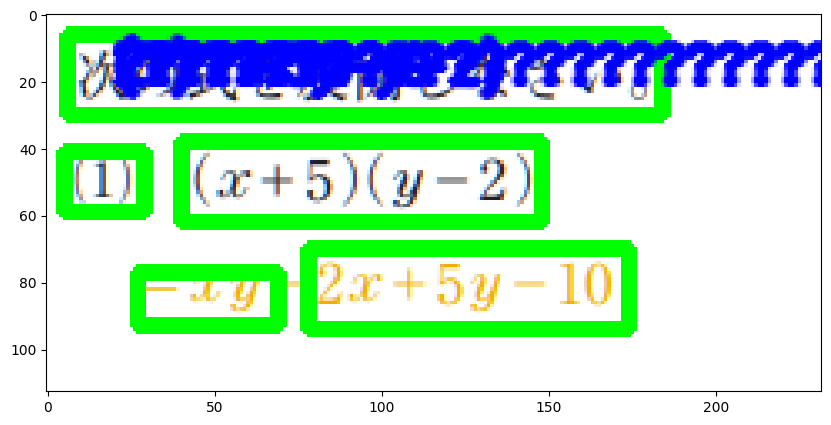

['次の式を展開しなさい。', '(1)', '(正十5 y-2)', '一じり', 'Zじ+5y-I0']


In [27]:
# Method call
# reader = easyocr.Reader(['en', 'ch_sim'])  # Support English, Chinese simplified
# reader = easyocr.Reader(['en', 'ch_tra'])  # Support English, Chinese traditional
# reader = easyocr.Reader(['en', 'ko'])  # Support English, Korean
reader = easyocr.Reader(['en', 'ja'])  # Support English, Japanese
# image_path = '../sample_images/formula_text/chinese/3.png'
image_path = '../sample_images/formula_text/japanese/2.png'
# image_path = '../sample_images/formula_only/1.png'
extracted_text = extract_text_with_bounding_boxes(image_path, reader)
print(extracted_text)